In [2]:
%matplotlib inline

import numpy as np
import threading
import time, os, json
import cv2
import matplotlib.pyplot as plt
import multiprocessing as mp

from scipy import stats, signal
from situtils import FPSTimes

In [3]:
# TODO - write an Agent class and unify position/HD tracking for multiple agents

In [4]:
class PositionTrackerBase(FPSTimes):
    
    default_cfg = {
        "single_agent": True,
        "background_light": "background_light.png",
        "background_dark": "background_dark.png",
        "threshold_light": 60,
        "threshold_dark": 30,
        "min_blob_size": 100,
        "subtract": 1,
        "arena_x": 522,
        "arena_y": 372,
        "arena_radius": 330,
        "floor_radius": 287,
        "max_fps": 50,
        "file_path": "positions.csv",
        "contour_path": "contours.csv",
        "floor_r_in_meters": 0.46,
        "angle_compensation": -90,
        "flip_x": True,
        "flip_y": False
    }
    
    def __init__(self, status, video_stream, cfg):
        super(PositionTrackerBase, self).__init__()
        
        self.status = status
        self.cfg = cfg
        self.video_stream = video_stream
        self.bg_light = cv2.imread(cfg['background_light'], 1)
        self.bg_dark  = cv2.imread(cfg['background_dark'], 1)
        self.background = self.bg_light  # light by default
        self.is_light = True
        self.pixel_size = cfg['floor_r_in_meters'] / float(cfg['floor_radius'])
        self.stopped = False
        self.mask = np.zeros(shape=self.background.shape, dtype="uint8")
        cv2.circle(self.mask, (cfg['arena_x'], cfg['arena_y']), cfg['arena_radius'], (255,255,255), -1)

    def reload_background(self):
        self.bg_light = cv2.imread(self.cfg['background_light'], 1)
        self.bg_dark  = cv2.imread(self.cfg['background_dark'], 1)
        self.background = self.bg_light if self.is_light else self.bg_dark
        print('Position tracker - background reloaded')

    def switch_background(self):
        self.background = self.bg_dark if self.is_light else self.bg_light 
        self.is_light = not self.is_light
        
    def px_to_meters(self, x, y):
        x_m = float(self.cfg['arena_x'] - x) * self.pixel_size * (-1 if self.cfg['flip_x'] else 1)
        y_m = float(self.cfg['arena_y'] - y) * self.pixel_size * (-1 if self.cfg['flip_y'] else 1)
        return x_m, y_m

    def meters_to_px(self, x, y):
        x_m = self.cfg['arena_x'] - (x / self.pixel_size) * (-1 if self.cfg['flip_x'] else 1)
        y_m = self.cfg['arena_y'] - (y / self.pixel_size) * (-1 if self.cfg['flip_y'] else 1)
        return int(x_m), int(y_m)

    def correct_angle(self, phi):
        return (2*np.pi - phi) + np.deg2rad(self.cfg['angle_compensation'])

    def is_inside(self, x, y, r):
        for pos in self.positions_in_m:
            if (pos[0] - x)**2 + (pos[1] - y)**2 <= r**2:
                return True
        return False
    
    def start(self):
        self._th = threading.Thread(target=self.update, args=())
        self._th.start()
    
    def stop(self):
        self.stopped = True
        self._th.join()
        print('Position tracker stopped')
        
    def update(self):
        next_frame = time.time() + 1.0/self.cfg['max_fps']
        
        while not self.stopped:
            frame = self.video_stream.read()
            if frame is None:
                time.sleep(0.05)
                continue
                
            if time.time() < next_frame:
                time.sleep(0.001)
                continue
                
            self.count()  # count FPS
            self.detect_position(frame)
            next_frame += 1.0/self.cfg['max_fps']

            if self.status.value == 2 and self.positions_in_px is not None:
                self.save_position()
                self.save_contours()                  

    # generic interface

    def detect_position(self, frame):
        return NotImplemented

    def save_position(self):
        return NotImplemented
    
    def save_contours(self):
        return NotImplemented
    
    @property
    def positions_in_px(self):
        # a list of pairs [(Xi, Yi), ...] of actual positions for each agent tracked - in pixels
        return NotImplemented
    
    @property
    def positions_in_m(self):
        # a list of pairs [(Xi, Yi), ...] of actual positions for each agent tracked - in meters
        return NotImplemented
    
    @property
    def contours(self):
        return NotImplemented
    
    @property
    def speeds(self):
        return NotImplemented
    
    @property
    def hds(self):
        return NotImplemented

In [5]:
class PositionTrackerSingleNOHD(PositionTrackerBase):
    
    def __init__(self, status, video_stream, cfg):
        super(PositionTrackerSingleNOHD, self).__init__(status, video_stream, cfg)
        
        self._position = None
        self._contour = None
        self._lr = None  # linear regression of the contour
        
        with open(cfg['file_path'], 'w') as f:
            f.write("time,x,y\n")
        with open(cfg['contour_path'], 'w') as f:
            f.write("x:y,...\n")
            
    def detect_position(self, frame):
        masked_frame = cv2.bitwise_and(src1=frame, src2=self.mask)

        # Substracts background from current frame or takes absdiff
        if 'subtract' in self.cfg:
            if self.cfg['subtract'] > 0:
                subject = cv2.subtract(self.background, masked_frame)
            else:
                subject = cv2.subtract(self.background, masked_frame)
        else:
            subject = cv2.absdiff(masked_frame, self.background)

        # Converts subject to grey scale
        subject_gray = cv2.cvtColor(subject, cv2.COLOR_BGR2GRAY)

        # Applies blur and thresholding to the subject
        kernel_size = (25,25)
        frame_blur = cv2.GaussianBlur(subject_gray, kernel_size, 0)
        th = self.cfg['threshold_light'] if self.is_light else self.cfg['threshold_dark']
        _, thresh = cv2.threshold(frame_blur, th, 255, cv2.THRESH_BINARY)

        # Finds contours and selects the contour with the largest area
        contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        if len(contours) == 0:
            return
        contour = contours[np.argmax(list(map(cv2.contourArea, contours)))]
        M = cv2.moments(contour)
        if (M['m00'] == 0):
            return

        self._position = np.array([M['m10'] / M['m00'], M['m01'] / M['m00']])
        self._contour = contour  # in pixels
        
        #ctr_in_px = np.array([x for x in zip(contour[:, 0, 0], contour[:, 0, 1])])
        #if ctr_in_px[:, 0].max() - ctr_in_px[:, 0].min() > ctr_in_px[:, 1].max() - ctr_in_px[:, 1].min():
        #    slope, intercept, r_value, p_value, std_err = stats.linregress(ctr_in_px[:, 0], ctr_in_px[:, 1])
        #    self.lr = {'slope': slope, 'intercept': intercept, 'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        #else:
        #    slope, intercept, r_value, p_value, std_err = stats.linregress(ctr_in_px[:, 1], ctr_in_px[:, 0])
        #    self.lr = {'slope': 1 - slope, 'intercept': intercept, 'r_value': r_value, 'p_value': p_value, 'std_err': std_err}

    def save_position(self):
        if self.positions_in_px is None:
            return
        with open(self.cfg['file_path'], 'a') as f:
            f.write(",".join([str(x) for x in (self.frame_times[-1], \
                   round(self.positions_in_m[0][0], 4), round(self.positions_in_m[0][1], 4))]) + "\n") 
    
    def save_contours(self):
        if self._contour is None:
            return
        ctr_in_m = np.array([self.px_to_meters(x, y) for x, y in zip(self._contour[:, 0, 0], self._contour[:, 0, 1])])
        data = ["%.4f:%.4f" % (x[0], x[1]) for x in ctr_in_m]
        with open(self.cfg['contour_path'], 'a+') as f:    
            f.write(",".join(data) + "\n")
    
    @property
    def positions_in_px(self):
        return [self._position.astype('int32')] if self._position is not None else None
    
    @property
    def positions_in_m(self):
        if self._position is None:
            return None
        x = (self.cfg['arena_x'] - self._position[0]) * self.pixel_size * (-1 if self.cfg['flip_x'] else 1)
        y = (self.cfg['arena_y'] - self._position[1]) * self.pixel_size * (-1 if self.cfg['flip_y'] else 1)
        return [np.array([x, y])]
    
    @property
    def contours(self):
        return [self._contour]

In [6]:
class PositionTrackerDouble(PositionTrackerBase):
    
    def __init__(self, status, video_stream, cfg):
        super(PositionTrackerDouble, self).__init__(status, video_stream, cfg)

        self._dist_array = []
        self._positions_list_1, self._positions_list_2 = None, None
        self._contour1, self._contour2 = [], []
       
        with open(cfg['file_path'], 'w') as f:
            f.write("time,x1,y1,x2,y2\n")
        with open(cfg['contour_path'], 'w') as f:
            f.write("x:y,...\n")

    def detect_position(self, frame):
        masked_frame = cv2.bitwise_and(src1=frame, src2=self.mask)

        # Substracts background from current frame or takes absdiff
        if 'subtract' in self.cfg:
            if self.cfg['subtract'] > 0:
                subject = cv2.subtract(self.background, masked_frame)
            else:
                subject = cv2.subtract(self.background, masked_frame)
        else:
            subject = cv2.absdiff(masked_frame, self.background)

        # Converts subject to grey scale
        subject_gray = cv2.cvtColor(subject, cv2.COLOR_BGR2GRAY)

        # Applies blur and thresholding to the subject
        kernel_size = (25,25)
        frame_blur = cv2.GaussianBlur(subject_gray, kernel_size, 0)
        th = self.cfg['threshold_light'] if self.is_light else self.cfg['threshold_dark']
        _, thresh = cv2.threshold(frame_blur, th, 255, cv2.THRESH_BINARY)

        # Finds contours and selects the contour with the largest area
        contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        # filter by size
        blobs = [cnt for cnt in contours if cv2.contourArea(cnt) > self.cfg['min_blob_size']]
        if len(blobs) == 0:  # do nothing if nothing is identified
            return
        
        sizes = [int(cv2.contourArea(blob)) for blob in blobs]
        blobs = [blobs[i] for i in np.argsort(sizes)][:2]  # two largest blobs
        
        if len(blobs) == 1:  # when two objects are together
            blobs.append(np.array(blobs[0]))
        
        #if np.random.rand() > 0.5:  # randomize for testing
        #    blobs[0], blobs[1] = blobs[1], blobs[0]
            
        M1 = cv2.moments(blobs[0])
        M2 = cv2.moments(blobs[1])
        if M1['m00'] == 0 or M2['m00'] == 0:
            return
        
        xy1 = np.array([M1['m10'] / M1['m00'], M1['m01'] / M1['m00']])  # single pair
        xy2 = np.array([M2['m10'] / M2['m00'], M2['m01'] / M2['m00']])  # single pair

        if self._positions_list_1 is None:  # first detected coordinates
            self._positions_list_1 = np.array([xy1])  # array of XY pairs
            self._positions_list_2 = np.array([xy2])  # array of XY pairs

        else:
            idx = 0 if len(self._positions_list_1) < 20 else 1  # append or shift position list, collecting position history

            # compute distance matrix: current XY1 and XY2 to previous positions
            dist_array = []
            for point in (xy1, xy2):
                for p_list in (self._positions_list_1, self._positions_list_2):
                    distance = np.sqrt( ((p_list[:, 0] - point[0]).mean())**2 + \
                        ((p_list[:, 1] - point[1]).mean())**2 )
                    dist_array.append(distance)

            self._dist_array = dist_array

            if np.argmin(np.array(dist_array)) < 1 or np.argmin(np.array(dist_array)) > 2: # 1 goes to 1, 2 to 2
                self._positions_list_1 = np.concatenate([self._positions_list_1[idx:], [xy1]])
                self._positions_list_2 = np.concatenate([self._positions_list_2[idx:], [xy2]])
                self._contour1, self._contour2 = blobs[0], blobs[1]
            else:  # swap
                self._positions_list_1 = np.concatenate([self._positions_list_1[idx:], [xy2]])
                self._positions_list_2 = np.concatenate([self._positions_list_2[idx:], [xy1]])
                self._contour1, self._contour2 = blobs[1], blobs[0]

    def save_position(self):
        if self.positions_in_px is None:
            return        
        with open(self.cfg['file_path'], 'a') as f:  # save position
            data = self.positions_in_m
            f.write(",".join([str(x) for x in (self.frame_times[-1], \
                   round(data[0][0], 4), round(data[0][1], 4), round(data[1][0], 4), round(data[1][1], 4))]) + "\n")         
                    
    def save_contours(self):
        if self.contours is None:
            return
        ctr1_in_m = np.array([self.px_to_meters(x, y) for x, y in zip(self._contour1[:, 0, 0], self._contour1[:, 0, 1])])
        ctr2_in_m = np.array([self.px_to_meters(x, y) for x, y in zip(self._contour2[:, 0, 0], self._contour2[:, 0, 1])])
        data1 = ["%.4f:%.4f" % (x[0], x[1]) for x in ctr1_in_m]
        data2 = ["%.4f:%.4f" % (x[0], x[1]) for x in ctr2_in_m]
        with open(self.cfg['contour_path'], 'a+') as f:    
            f.write(",".join(data1) + ";" + ",".join(data2) + "\n") 
                
    @property
    def positions_in_px(self):
        if self._positions_list_1 is None:
            return None
        x1, y1 = self._positions_list_1[-1].astype('int32')
        x2, y2 = self._positions_list_2[-1].astype('int32')
        return np.array([[x1, y1], [x2, y2]])
    
    @property
    def positions_in_m(self):
        if self._positions_list_1 is None:
            return None
        x1 = (self.cfg['arena_x'] - self._positions_list_1[-1][0]) * self.pixel_size * (-1 if self.cfg['flip_x'] else 1)
        y1 = (self.cfg['arena_y'] - self._positions_list_1[-1][1]) * self.pixel_size * (-1 if self.cfg['flip_y'] else 1)
        x2 = (self.cfg['arena_x'] - self._positions_list_2[-1][0]) * self.pixel_size * (-1 if self.cfg['flip_x'] else 1)
        y2 = (self.cfg['arena_y'] - self._positions_list_2[-1][1]) * self.pixel_size * (-1 if self.cfg['flip_y'] else 1)
        return np.array([[x1, y1], [x2, y2]])
        
    @property
    def contours(self):  # always in pixels
        return [self._contour1, self._contour2] if self._contour1 is not None else None
    
    @property
    def speeds(self):
        # Not Implemented
        return [0, 0] if self.positions_in_px is not None else None
    
    @property
    def hds(self):
        # Not Implemented
        return [0, 0] if self.positions_in_px is not None else None

In [7]:
class PositionTrackerSingle(PositionTrackerBase):
    
    def __init__(self, status, video_stream, cfg):
        super(PositionTrackerSingle, self).__init__(status, video_stream, cfg)
        
        # an array of [[t1, X1, Y1, speed1, HD1], [t2, X2, Y2, speed2, HD2], ...] of 'history_duration' length
        # X, Y - in pixels, Speed - in m/s, head direction (HD) - in rad
        self._positions_list = None  
        self._contour = None
        self._lr = None  # linear regression of the contour
        
        width = 50  # 50 points ~= 1 sec with at 50Hz - to smooth the trajectory
        self.kernel = signal.gaussian(width, std=(width) / 7.2)
        
        with open(cfg['file_path'], 'w') as f:
            f.write("time,x,y\n")
        with open(cfg['contour_path'], 'w') as f:
            f.write("x:y,...\n")
            
    def detect_position(self, frame):
        masked_frame = cv2.bitwise_and(src1=frame, src2=self.mask)

        # Substracts background from current frame or takes absdiff
        if 'subtract' in self.cfg:
            if self.cfg['subtract'] > 0:
                subject = cv2.subtract(self.background, masked_frame)
            else:
                subject = cv2.subtract(self.background, masked_frame)
        else:
            subject = cv2.absdiff(masked_frame, self.background)

        # Converts subject to grey scale
        subject_gray = cv2.cvtColor(subject, cv2.COLOR_BGR2GRAY)

        # Applies blur and thresholding to the subject
        kernel_size = (25,25)
        frame_blur = cv2.GaussianBlur(subject_gray, kernel_size, 0)
        th = self.cfg['threshold_light'] if self.is_light else self.cfg['threshold_dark']
        _, thresh = cv2.threshold(frame_blur, th, 255, cv2.THRESH_BINARY)

        # Finds contours and selects the contour with the largest area
        contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

        if len(contours) == 0:
            return
        contour = contours[np.argmax(list(map(cv2.contourArea, contours)))]
        M = cv2.moments(contour)
        if (M['m00'] == 0):
            return

        x, y = M['m10'] / M['m00'], M['m01'] / M['m00']
        if self._positions_list is None:
            self._positions_list = np.array([[time.time(), x, y, 0, 0]])
        else:
            t1 = time.time() - self.cfg['history_duration']
            idx = np.argmin(np.abs(self._positions_list[:, 0] - t1))
            last_hd = self._positions_list[-1][4]
            self._positions_list = np.concatenate([self._positions_list[idx:], [np.array([time.time(), x, y, 0, last_hd])]])

        # speed
        if len(self._positions_list) > len(self.kernel):
            x = (-self._positions_list[:, 1] + self.cfg['arena_x']) * self.pixel_size * (-1 if self.cfg['flip_x'] else 1)
            y = (-self._positions_list[:, 2] + self.cfg['arena_y']) * self.pixel_size * (-1 if self.cfg['flip_y'] else 1)
            
            # to avoid boundary effects
            x = np.concatenate([np.ones(int(len(self.kernel)/2) - 1) * x[0], x, np.ones(int(len(self.kernel)/2)) * x[-1]])
            y = np.concatenate([np.ones(int(len(self.kernel)/2) - 1) * y[0], y, np.ones(int(len(self.kernel)/2)) * y[-1]])
            
            x_smooth = np.convolve(x, self.kernel, 'valid') / self.kernel.sum()  # valid mode to avoid boundary effects
            y_smooth = np.convolve(y, self.kernel, 'valid') / self.kernel.sum()

            dx = np.sqrt(np.square(np.diff(x_smooth)) + np.square(np.diff(y_smooth)))
            dt = np.diff(self._positions_list[:, 0])
            speed = np.concatenate([dx/dt, [dx[-1]/dt[-1]]])
            self._positions_list[:, 3] = speed  # in m/s
        
        # head direction
        recent_traj = self._positions_list[self._positions_list[:, 0] > time.time() - 0.25]
        avg_speed = recent_traj[:, 3].mean()
        if avg_speed > self.cfg['hd_update_speed'] and len(recent_traj) > 3:  # if animal runs basically
            x, y = recent_traj[0][1], recent_traj[0][2]
            vectors = [np.array([a[1], a[2]]) - np.array([x, y]) for a in recent_traj[1:]]
            avg_direction = np.array(vectors).sum(axis=0) / len(vectors)

            avg_angle = -np.arctan2(avg_direction[1], avg_direction[0])
            self._positions_list[-1][4] = avg_angle  # in radians
                
        self._contour = contour  # in pixels
        
        #ctr_in_px = np.array([x for x in zip(contour[:, 0, 0], contour[:, 0, 1])])
        #if ctr_in_px[:, 0].max() - ctr_in_px[:, 0].min() > ctr_in_px[:, 1].max() - ctr_in_px[:, 1].min():
        #    slope, intercept, r_value, p_value, std_err = stats.linregress(ctr_in_px[:, 0], ctr_in_px[:, 1])
        #    self.lr = {'slope': slope, 'intercept': intercept, 'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        #else:
        #    slope, intercept, r_value, p_value, std_err = stats.linregress(ctr_in_px[:, 1], ctr_in_px[:, 0])
        #    self.lr = {'slope': 1 - slope, 'intercept': intercept, 'r_value': r_value, 'p_value': p_value, 'std_err': std_err}

    def save_position(self):
        if self.positions_in_px is None:
            return
        with open(self.cfg['file_path'], 'a') as f:
            f.write(",".join([str(x) for x in (self.frame_times[-1], \
                   round(self.positions_in_m[0][0], 4), round(self.positions_in_m[0][1], 4))]) + "\n") 
    
    def save_contours(self):
        if self.contours is None:
            return
        ctr_in_m = np.array([self.px_to_meters(x, y) for x, y in zip(self._contour[:, 0, 0], self._contour[:, 0, 1])])
        data = ["%.4f:%.4f" % (x[0], x[1]) for x in ctr_in_m]
        with open(self.cfg['contour_path'], 'a+') as f:    
            f.write(",".join(data) + "\n")
    
    @property
    def positions_in_px(self):
        return [self._positions_list[-1][1:].astype('int32')] if self._positions_list is not None else None
    
    @property
    def positions_in_m(self):
        if self._positions_list is None:
            return None
        x = (self.cfg['arena_x'] - self._positions_list[-1][1]) * self.pixel_size * (-1 if self.cfg['flip_x'] else 1)
        y = (self.cfg['arena_y'] - self._positions_list[-1][2]) * self.pixel_size * (-1 if self.cfg['flip_y'] else 1)
        return [np.array([x, y])]
    
    @property
    def contours(self):
        return [self._contour] if self._contour is not None else None
    
    @property
    def speeds(self):
        return [self._positions_list[-1][3]] if self._positions_list is not None else None
    
    @property
    def hds(self):
        return [np.degrees(self._positions_list[-1][4])] if self._positions_list is not None else None

### Testing position detection

In [8]:
with open(os.path.join('..', 'profiles', 'default.json')) as json_file:
    cfg = json.load(json_file)

pt_cfg = cfg['position']
pt_cfg['background_light'] = os.path.join('..', 'assets', 'background_light.png')
pt_cfg['background_dark'] = os.path.join('..', 'assets', 'background_dark.png')

In [11]:
#import nbimporter
#from camera import WebcamStream

# controller status: 1 - detecting, 2 - detecting + logging
status = mp.Value('i', 1)

# let's use a webcam stream
vs = WebcamStream(cfg['camera'])
vs.start()  # stream runs in a separate thread

# init controller
#pt = DoublePositionTracker(status, vs, pt_cfg)
pt = PositionTrackerSingle(status, vs, pt_cfg)
pt.start()
kernel_size = (25,25)

try:
    while True:
        frame = vs.read()
        if frame is not None:
            masked_frame = cv2.bitwise_and(src1=frame, src2=pt.mask)
            frame_to_save = masked_frame.copy()
            #masked_frame = cv2.absdiff(masked_frame, pt.background)
            #masked_frame = cv2.subtract(pt.background, masked_frame)
            #masked_frame = cv2.subtract(masked_frame, pt.background)
            #masked_frame = cv2.cvtColor(masked_frame, cv2.COLOR_BGR2GRAY)
            #masked_frame = cv2.GaussianBlur(masked_frame, kernel_size, 0)
            
            cv2.putText(masked_frame, 'Position: %.2f FPS' % pt.get_avg_fps(), 
                     (10, 80), cv2.FONT_HERSHEY_DUPLEX, .5, (255, 255, 255))        
            
            if pt.positions_in_px is not None:
                color1 = (127, 255, 0)
                #color2 = (0, 0, 255)
                cv2.circle(masked_frame, (pt.positions_in_px[0][0], pt.positions_in_px[0][1]), 2, color1, -1)
                #cv2.circle(masked_frame, (pt.xy2_in_px[0], pt.xy2_in_px[1]), 2, color2, -1)
                
                cv2.drawContours(masked_frame, [pt.contours[0]], 0, color1, 1, cv2.LINE_AA)
                #cv2.drawContours(masked_frame, [pt.contour2], 0, color2, 1, cv2.LINE_AA)
                
                cv2.putText(masked_frame, 'Animal1: %.3f %.3f %d' % (pt.positions_in_m[0][0], pt.positions_in_m[0][1], \
                         cv2.contourArea(pt.contours[0])), (10, 40), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))
                cv2.putText(masked_frame, 'History: %d' % (len(pt._positions_list)), \
                            (10, 60), cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))
            
                # regression line
                #if pt.lr is not None:
                #    x1, x2 = pt.contour[:, 0, 0].min() - 10, pt.contour[:, 0, 0].max() + 10
                #    y1, y2 = int(x1 * pt.lr['slope'] + pt.lr['intercept']), int(x2 * pt.lr['slope'] + pt.lr['intercept'])
                #    cv2.line(frame, (x1, y1), (x2, y2), color, 1)
            
            cv2.putText(masked_frame, 'L' if pt.is_light else 'D', (10, 20), cv2.FONT_HERSHEY_DUPLEX, .5, (255, 255, 255))            
            cv2.imshow('Webcam', masked_frame)

        k = cv2.waitKey(33)
        if k == ord('q'):
            break
            
        if k == ord('s'):
            status.value = 2 if status.value == 1 else 1

        if k == ord('d'):
            pt.switch_background()
            
        if k == ord('r'):
            cv2.imwrite('frame.jpg', frame_to_save)
                       
finally:
    cv2.destroyAllWindows()
    vs.stop(), pt.stop()

Webcam stream 1024.0:768.0 at 30.00 FPS started
Camera released
Position tracker stopped


### Image sandbox

In [6]:
masked_frame = cv2.imread('frame.jpg')
bg_light = cv2.imread(cfg['position']['background_light'], 1)
subjects = cv2.subtract(bg_light, masked_frame)
subjects_gray = cv2.cvtColor(subjects, cv2.COLOR_BGR2GRAY)

kernel_size = (25,25)
subjects_blur = cv2.GaussianBlur(subjects_gray, kernel_size, 0)
th = cfg['position']['threshold_light']  # in light
_, thresh = cv2.threshold(subjects_blur, th, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

contour = contours[np.argmax(list(map(cv2.contourArea, contours)))]

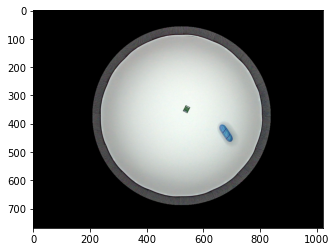

In [7]:
plt.imshow(masked_frame)

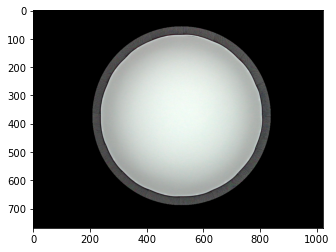

In [8]:
plt.imshow(bg_light)

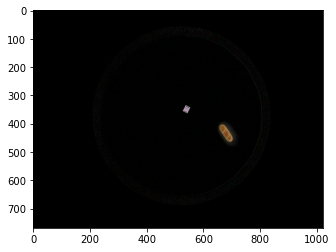

In [9]:
plt.imshow(subjects)

In [10]:
cv2.contourArea(contours[1])

410.0

In [49]:
a1 = np.array([12, 56, 5, 5])
np.argmin(a1)

2

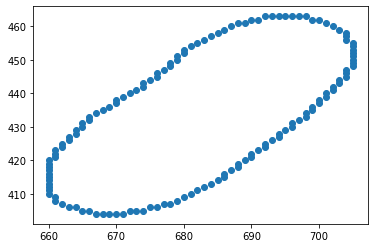

In [40]:
plt.scatter(contours[0][:, 0][:, 0], contours[0][:, 0][:, 1])

In [20]:
x.astype('int64')

array([3, 1, 2], dtype=int64)

In [17]:
x = np.array([3, 1, 2])
idxs = np.argsort(x)
idxs

array([1, 2, 0], dtype=int64)

In [16]:
x[idxs]

array([1, 2, 3])

In [8]:
image = cv2.imread('frame.jpg')
#plt.imshow(image)

In [9]:
image[0][0]

array([0, 0, 0], dtype=uint8)

In [ ]:
color = ('b','g','r')
for channel, col in enumerate(color):
    histr = cv2.calcHist([image],[channel],None,[256],[0,256])
    plt.plot(histr, color = col)
    plt.xlim([0,256])
    plt.ylim([0, 1000])

## Contour test

In [ ]:
x, y = contour[0][0][0], contour[0][0][1]
pt.px_to_meters(x, y), len(contour)

In [ ]:
ctr_in_m = np.array([pt.px_to_meters(x, y) for x, y in zip(contour[:, 0, 0], contour[:, 0, 1])])
ctr_in_px = np.array([x for x in zip(contour[:, 0, 0], contour[:, 0, 1])])

In [ ]:
import matplotlib.pyplot as plt
from scipy import stats

x = ctr_in_px[:, 0]
y = ctr_in_px[:, 1]

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
x_line = np.linspace(x.min(), x.max(), 10)
y_line = x_line * slope + intercept

plt.scatter(x, y)
plt.plot(x_line, y_line)

In [5]:
filename = 'D:\\runSIT\\sessions\\52_aSIT_2021-11-15_11-12-00\\contours.csv'
with open(filename) as ff:
    data = ff.readlines()

headers = data[0]   # skip headers line
contours = [[(float(x.split(':')[0]), float(x.split(':')[1])) for x in contour.split(',')] for contour in data[1:]]
contours = [np.array(contour) for contour in contours]

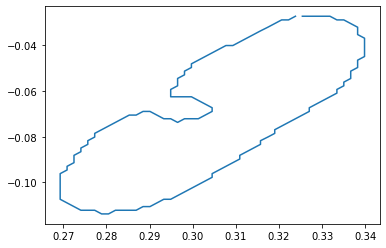

In [8]:
plt.plot(contours[0][:, 0], contours[0][:, 1])